In [1]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm  # For displaying progress bars
from datasets import load_dataset  # For loading datasets
from sklearn.model_selection import train_test_split  # For splitting the dataset
from transformers import BertTokenizer  # For tokenizing text
from torch.utils.data import TensorDataset  # For creating Tensor datasets
import time  # For measuring time
from sklearn.metrics import accuracy_score, precision_score, f1_score  # For evaluation metrics
from sklearn.exceptions import UndefinedMetricWarning  # For handling metric warnings
import matplotlib.pyplot as plt  # For plotting
from tabulate import tabulate  # For tabular data formatting
import random  # For randomization
import numpy as np  # For numerical operations
from transformers import (
    BertTokenizer,  # Tokenizer for BERT models
    AdamW,  # Optimizer for BERT models
    get_linear_schedule_with_warmup,  # Learning rate scheduler for BERT models
    BertConfig,  # Configuration for BERT models
    BertForSequenceClassification  # BERT model for sequence classification tasks
)
from torch.utils.data import (
    DataLoader,  # Data loader for creating batches
    RandomSampler,  # Sampler for random sampling of data
    SequentialSampler  # Sampler for sequential sampling of data
)
from sklearn.metrics import f1_score  # For computing the F1 score
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
# 1. Torch: PyTorch library for deep learning
# 2. Pandas: Library for data manipulation and analysis
# 3. tqdm: Library for displaying progress bars
# 4. datasets: Library for working with datasets
# 5. train_test_split: Function for splitting the dataset into training and validation sets
# 6. BertTokenizer: Tokenizer for BERT models
# 7. TensorDataset: Dataset class for creating PyTorch Tensor datasets
# 8. time: Module for measuring time
# 9. accuracy_score, precision_score, f1_score: Evaluation metrics for classification tasks
# 10. UndefinedMetricWarning: Warning for undefined metric values
# 11. matplotlib.pyplot: Plotting library
# 12. tabulate: Library for formatting tabular data
# 13. random: Module for randomization
# 14. numpy: Library for numerical operations
# 15. AdamW: Optimizer for BERT models
# 16. get_linear_schedule_with_warmup: Learning rate scheduler for BERT models
# 17. BertConfig: Configuration for BERT models
# 18. BertForSequenceClassification: BERT model for sequence classification tasks
# 19. DataLoader: Data loader for creating batches
# 20. RandomSampler: Sampler for random sampling of data
# 21. SequentialSampler: Sampler for sequential sampling of data
# 22. f1_score: Function for computing the F1 score

2023-07-31 21:56:54.039518: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-31 21:56:54.064636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 21:56:54.512193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def count_words(text):
    words = word_tokenize(text)
    return len(words)

def datacleaning_amazon():
    dataset = load_dataset("amazon_us_reviews", "Apparel_v1_00")
    train_data = dataset['train']

    train_data = train_data.select(range(50000))

    # Filter rows with review_body length less than or equal to 256 words
    train_data = train_data.filter(lambda example: count_words(example['review_body']) <= 256)

    # Limit the dataset to the first 10,000 rows
    train_data = train_data.select(range(10000))

    df = train_data.to_pandas()  # Convert the dataset to a Pandas DataFrame
    df = df[['customer_id', 'review_headline', 'review_body', 'star_rating']]  # Select specific columns
    df.columns = ['customer_id', 'review_headline', 'review_body', 'star_rating']  # Rename the selected columns
    df.set_index('customer_id', inplace=True)

    df['sentiment'] = df['star_rating'].map({5: 'good', 4: 'good', 3: 'neutral', 2: 'bad', 1: 'bad'})

    possible_labels = df.sentiment.unique()  # Get unique category labels from the DataFrame column 'category'

    label_dict = {}  # Create a dictionary to map each possible label to a unique index
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index

    df['label'] = df.sentiment.replace(label_dict)

    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        df.index.values,
        df.label.values,
        test_size=0.15,
        random_state=17,
        stratify=df.label.values
    )

    df['data_type'] = ['not_set'] * df.shape[0]  # Set a new column 'data_type' for later data split

    # Set the 'data_type' column of the dataframe for training and validation data
    df.loc[X_train, 'data_type'] = 'train'
    df.loc[X_val, 'data_type'] = 'val'

    return df

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

def accuracy_per_class(preds, labels, label_dict):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Initialize the confusion matrix.
    num_classes = len(label_dict)
    confusion_mat = confusion_matrix(labels_flat, preds_flat, labels=list(range(num_classes)))
    
    # Calculate accuracy and F1 score per class
    accuracies = {}
    f1_scores = {}
    for label in range(num_classes):
        # Calculate accuracy for this class
        num_correct = confusion_mat[label, label]
        num_instances = np.sum(confusion_mat[label, :])
        accuracy = num_correct / num_instances * 100
        accuracies[label] = accuracy
        
        # Calculate F1 score for this class
        f1 = f1_score(labels_flat, preds_flat, labels=[label], average='weighted')
        f1_scores[label] = f1

        # Print the class name, accuracy numerator, and denominator.
        class_name = label_dict_inverse[label]
        print(f'Class: {class_name}')
        print(f'Accuracy: {num_correct}/{num_instances} ({accuracy:.2f}%)')
        print(f'F1 Score: {f1:.2f}\n')

    # Calculate total accuracy and F1 score
    total_accuracy = accuracy_score(labels_flat, preds_flat) * 100
    total_f1_score = f1_score(labels_flat, preds_flat, average='weighted')

    # Print the total accuracy and F1 score
    print(f'Total Accuracy: {total_accuracy:.2f}%')
    print(f'Total F1 Score: {total_f1_score:.2f}')


#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals

def train_model(trainer, dataloader_train, dataloader_val, epochs, patience):
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output = model(**inputs)
            loss = output[0]
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_gpt_bert_amazon_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                tqdm.write('\nEarly stopping triggered. Training stopped.')
                break
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create the x-axis values based on the actual number of epochs completed
    x_values = range(1, len(training_loss_list) + 1)
    
    # Create the metrics subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(x_values, training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(x_values, validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(x_values, f1_score_list, label='F1 Score')

    # Plot Accuracy
    ax.plot(x_values, accuracy_list, label='Accuracy')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()
    
    
    # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, len(training_loss_list) + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if accuracy_list[epoch - 1] > previous_results['val_f1']:
                row[4] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if accuracy_list[epoch - 1] < previous_results['val_f1']:
                row[4] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if precision_list[epoch - 1] > previous_results['val_f1']:
                row[5] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if precision_list[epoch - 1] < previous_results['val_f1']:
                row[5] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))

    return training_loss_list, validation_loss_list, accuracy_list, precision_list, f1_score_list

default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [3]:
df = datacleaning_amazon()

Found cached dataset amazon_us_reviews (/home/z123010/.cache/huggingface/datasets/amazon_us_reviews/Apparel_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/z123010/.cache/huggingface/datasets/amazon_us_reviews/Apparel_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563/cache-39524de3311549b5.arrow


In [4]:
# Create label_dict and assign the number of labels
label_dict = {label: index for index, label in enumerate(df['label'].unique())}

In [5]:
df.sample(n=10, random_state=42)  # Generate 10 random rows from df

,review_headline,review_body,star_rating,sentiment,label,data_type
customer_id,,,,,,
50867430,Absolutely must,Fits great! Feels comfortable! An overall grea...,5,good,0,train
14094716,Five Stars,Item is ok,5,good,0,val
36322626,Two Stars,This shirt runs extremely small. I generally ...,2,bad,2,train
16521558,Five Stars,Love it,5,good,0,train
28567406,Five Stars,Great for computer backups.,5,good,0,train
28796755,Five Stars,"Great fit, very comfortable!",5,good,0,train
159429,Runs Very Small,The product looks like the picture and the fab...,4,good,0,train
117231,Five Stars,"I luv it,",5,good,0,train
1965478,Ugh.,"I bought this design and one other, both XXL, ...",1,bad,2,val


[nltk_data] Downloading package punkt to /home/z123010/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


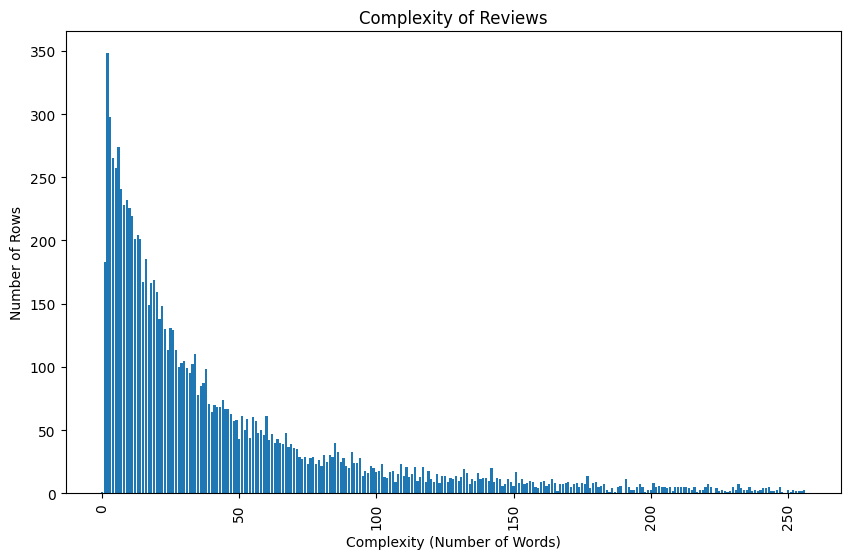

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize

# Download the punkt tokenizer (if not already downloaded)
nltk.download('punkt')

# Function to count the number of words in a given text
def count_words(text):
    words = word_tokenize(text)
    return len(words)

# Apply the count_words function to each row of the review_body column
df['word_count'] = df['review_body'].apply(count_words)

# Group by the word_count and count how many rows have reviews of that length
word_count_df = df['word_count'].value_counts().reset_index()
word_count_df.columns = ['Complexity (Number of Words)', 'Number of Rows']

# Sort the DataFrame by the complexity (number of words) in ascending order
word_count_df.sort_values(by='Complexity (Number of Words)', inplace=True)

# Create a bar plot to visualize the complexity and the number of rows
plt.figure(figsize=(10, 6))
plt.bar(word_count_df['Complexity (Number of Words)'], word_count_df['Number of Rows'])
plt.xlabel('Complexity (Number of Words)')
plt.ylabel('Number of Rows')
plt.title('Complexity of Reviews')
plt.xticks(rotation=90)
plt.show()


In [7]:
df.groupby(['star_rating', 'label', 'data_type']).count()

review_headline  review_body  sentiment   
star_rating label data_type                                            
1           2     train                  907          907        907  \
                  val                    190          190        190   
2           2     train                  490          490        490   
                  val                     83           83         83   
3           1     train                  683          683        683   
                  val                    135          135        135   
4           0     train                 1330         1330       1330   
                  val                    261          261        261   
5           0     train                 4665         4665       4665   
                  val                   1256         1256       1256   

                             word_count  
star_rating label data_type              
1           2     train             907  
                  val               190  
2           2     train             490  
                  val                83  
3           1     train             683  
                  val               135  
4           0     train            1330  
                  val               261  
5           0     train            4665  
                  val              1256

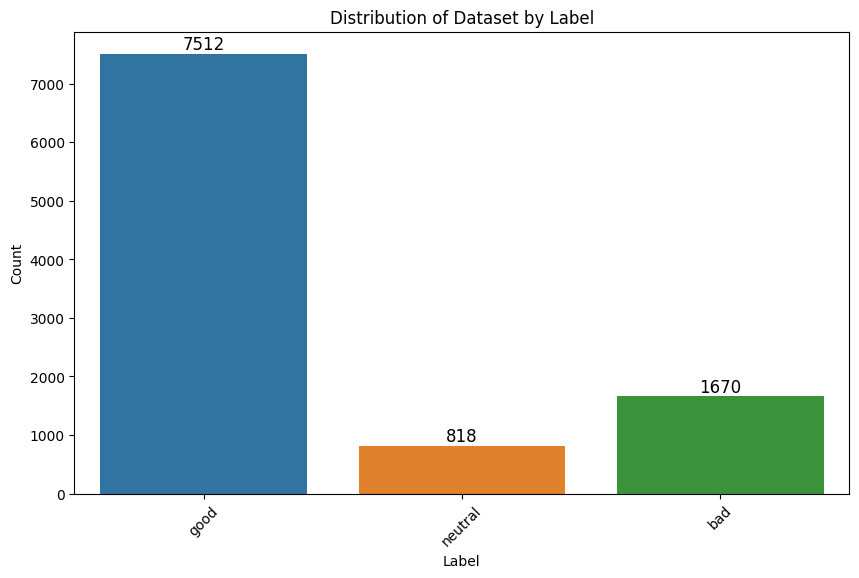

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the data already grouped as mentioned in your initial code
grouped_data = df.groupby(['label']).count()

# Reset the index to access the 'label' and 'data_type' columns
grouped_data.reset_index(inplace=True)

# Map numeric labels to text labels
label_mapping = {0: 'good', 1: 'neutral', 2: 'bad'}
grouped_data['label'] = grouped_data['label'].map(label_mapping)

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='data_type', data=grouped_data)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Dataset by Label')

# Add count numbers as annotations to each bar
for index, row in grouped_data.iterrows():
    count = row['data_type']
    plt.text(index, count, str(count), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45)
plt.show()


In [9]:
# Load BERT tokenizer
pretrained_path = 'gpt2'  # Replace with the path to the pretrained BERT model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

encoded_data_train_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_train_body = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_train_headline = encoded_data_train_headline['input_ids']
attention_masks_train_headline = encoded_data_train_headline['attention_mask']

input_ids_train_body = encoded_data_train_body['input_ids']
attention_masks_train_body = encoded_data_train_body['attention_mask']

input_ids_train = torch.cat((input_ids_train_headline, input_ids_train_body), dim=1)
attention_masks_train = torch.cat((attention_masks_train_headline, attention_masks_train_body), dim=1)

labels_train = torch.tensor(df[df.data_type=='train'].label.values)


encoded_data_val_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val_body = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_val_headline = encoded_data_val_headline['input_ids']
attention_masks_val_headline = encoded_data_val_headline['attention_mask']

input_ids_val_body = encoded_data_val_body['input_ids']
attention_masks_val_body = encoded_data_val_body['attention_mask']

input_ids_val = torch.cat((input_ids_val_headline, input_ids_val_body), dim=1)
attention_masks_val = torch.cat((attention_masks_val_headline, attention_masks_val_body), dim=1)

labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [10]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

(8075, 1925)

In [11]:
from transformers import BertModel, BertConfig, GPT2Model, GPT2Config

num_classes = 3

class SentimentModel(nn.Module):
    def __init__(self, pretrained_bert_path, pretrained_gpt_path):
        super(SentimentModel, self).__init__()

        gpt_config = GPT2Config.from_pretrained(
            pretrained_gpt_path,
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.3)
        self.gpt = GPT2Model.from_pretrained(pretrained_gpt_path, config=gpt_config)
        
        bert_config = BertConfig.from_pretrained(pretrained_bert_path)
        self.bert = BertModel.from_pretrained(pretrained_bert_path, config=bert_config)
        
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(bert_config.hidden_size + gpt_config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        gpt_outputs = self.gpt(input_ids, attention_mask=attention_mask)[0]
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask)[0]
        
        gpt_last_hidden_state = self.dropout(gpt_outputs[:, -1, :])  # Use the last hidden state
        bert_pooled_output = self.dropout(bert_outputs[:, 0, :])  # Use the [CLS] token representation
        
        combined_outputs = torch.cat((gpt_last_hidden_state, bert_pooled_output), dim=1)
        
        logits = self.fc(combined_outputs)
        outputs = nn.functional.softmax(logits, dim=1)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, num_classes), labels.view(-1))
            return loss, outputs, labels
        else:
            return outputs

In [12]:
# Create model instance
model = SentimentModel('bert-base-uncased', 'gpt2')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (gpt): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddin

In [14]:
# Count total params, trainable params, and non-trainable params
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

# Print the results
print(f"Total Params: {total_params}")
print(f"Trainable Params: {trainable_params}")
print(f"Non-trainable Params: {non_trainable_params}")

Total Params: 233926659
Trainable Params: 233926659
Non-trainable Params: 0


In [15]:
from transformers import TrainingArguments, Trainer, logging
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
)

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Set the batch size and create data loaders for training and validation sets

batch_size = 8 #32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

In [18]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Define the optimizer
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8,
    weight_decay=0.01

)


epochs = 10
patience = 3
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

/home/z123010/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda



Fold 1


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.38130100767544844
Validation loss: 0.34776208796861147
F1 Score (weighted): 0.8898452224392372


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.22809850042295415
Validation loss: 0.3636008644237939
F1 Score (weighted): 0.9041617583149782
40.18% Training loss decreased compared to the previous epoch
4.55% Validation loss increased compared to the previous epoch
1.61% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.14713395127686868
Validation loss: 0.4950048807210382
F1 Score (weighted): 0.8958913999937665
35.5% Training loss decreased compared to the previous epoch
36.14% Validation loss increased compared to the previous epoch
0.91% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.09252250998395196
Validation loss: 0.6210442615926451
F1 Score (weighted): 0.8947151180892281
37.12% Training loss decreased compared to the previous epoch
25.46% Validation loss increased compared to the previous epoch
0.13% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 31.13680280049642 minutes
Final Accuracy: 0.8928792569659443
Final Precision: 0.896887349913418


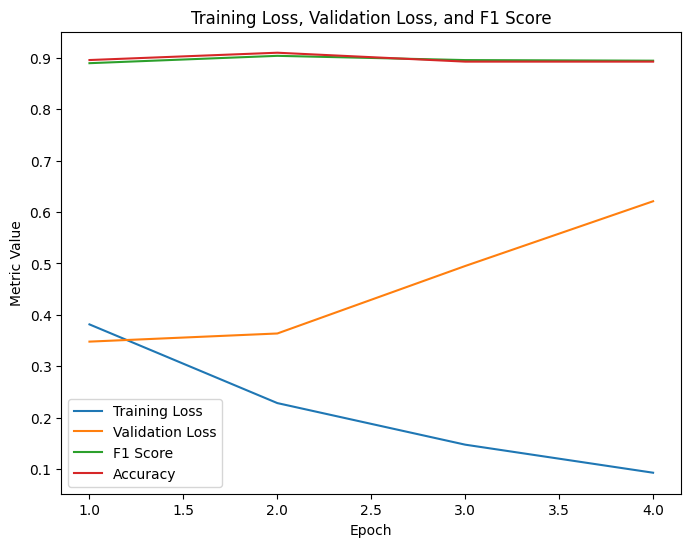

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.38130100767544844  0.34776208796861147  0.8898452224392372  0.8959752321981425     0.890398
2                     0.22809850042295415  0.3636008644237939   0.9041617583149782  0.9041617583149782     0.904162
3                     0.14713395127686868  0.4950048807210382   0.8958913999937665  0.8958913999937665     0.895891
4                     0.09252250998395196  0.6210442615926451   0.8947151180892281  0.8947151180892281     0.894715
Total Training Time                                                                                     1868.21
Final Precision                                                                                            0.896887
Total Time (minutes)                                                        

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.16364641940847355
Validation loss: 0.052608245948132466
F1 Score (weighted): 0.9867494203999175


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.10514844075796735
Validation loss: 0.043373738031282257
F1 Score (weighted): 0.9893668514187047
35.75% Training loss decreased compared to the previous epoch
17.55% Validation loss decreased compared to the previous epoch
0.27% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0710756655212163
Validation loss: 0.03172027405399955
F1 Score (weighted): 0.9931685867459398
32.4% Training loss decreased compared to the previous epoch
26.87% Validation loss decreased compared to the previous epoch
0.38% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.04179307794736202
Validation loss: 0.0376989476953715
F1 Score (weighted): 0.9926079451557417
41.2% Training loss decreased compared to the previous epoch
18.85% Validation loss increased compared to the previous epoch
0.06% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.03223175163501504
Validation loss: 0.037957825132144705
F1 Score (weighted): 0.9925175872146652
22.88% Training loss decreased compared to the previous epoch
0.69% Validation loss increased compared to the previous epoch
0.01% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.02700710873941176
Validation loss: 0.04544421425471048
F1 Score (weighted): 0.9918902401328036
16.21% Training loss decreased compared to the previous epoch
19.72% Validation loss increased compared to the previous epoch
0.06% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 46.62203215758006 minutes
Final Accuracy: 0.9919504643962849
Final Precision: 0.9919750360263799


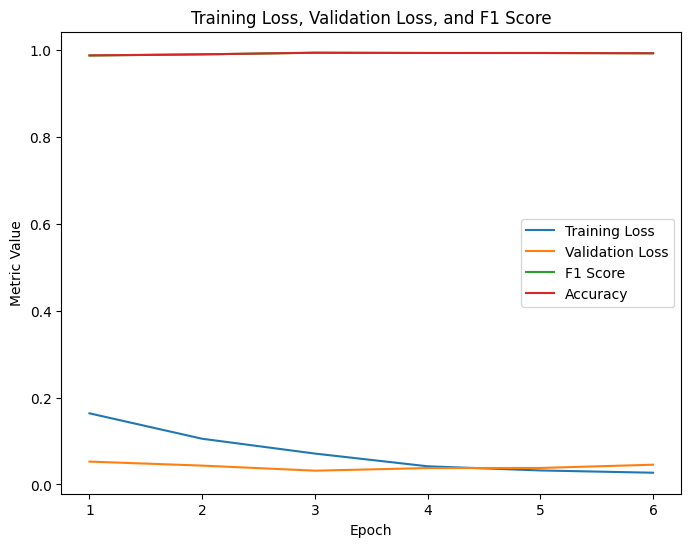

Epoch                 Training Loss        Validation Loss       F1 Score            Accuracy              Precision
--------------------  -------------------  --------------------  ------------------  ------------------  -----------
1                     0.16364641940847355  0.052608245948132466  0.9867494203999175  0.9869969040247678     0.987109
2                     0.10514844075796735  0.043373738031282257  0.9893668514187047  0.9893668514187047     0.989367
3                     0.0710756655212163   0.03172027405399955   0.9931685867459398  0.9931685867459398     0.993169
4                     0.04179307794736202  0.0376989476953715    0.9926079451557417  0.9926079451557417     0.992608
5                     0.03223175163501504  0.037957825132144705  0.9925175872146652  0.9925175872146652     0.992518
6                     0.02700710873941176  0.04544421425471048   0.9918902401328036  0.9918902401328036     0.99189
Total Training Time                                              

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.027257975395392656
Validation loss: 0.0045836058537647075
F1 Score (weighted): 0.9993797090223977


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.02005265000360229
Validation loss: 0.004706356550885553
F1 Score (weighted): 0.9993797090223977
26.43% Training loss decreased compared to the previous epoch
2.68% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.015489289543758318
Validation loss: 0.0047112932175711495
F1 Score (weighted): 0.9993797090223977
22.76% Training loss decreased compared to the previous epoch
0.1% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.015683037390812893
Validation loss: 0.004711317825852591
F1 Score (weighted): 0.9993797090223977
1.25% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 31.092485324541727 minutes
Final Accuracy: 0.9993808049535604
Final Precision: 0.9993813158405624


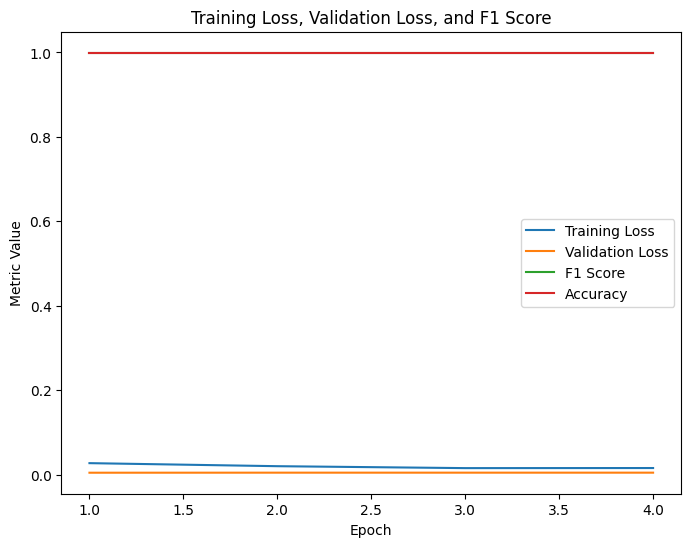

Epoch                 Training Loss         Validation Loss        F1 Score            Accuracy              Precision
--------------------  --------------------  ---------------------  ------------------  ------------------  -----------
1                     0.027257975395392656  0.0045836058537647075  0.9993797090223977  0.9993808049535604     0.999381
2                     0.02005265000360229   0.004706356550885553   0.9993797090223977  0.9993797090223977     0.99938
3                     0.015489289543758318  0.0047112932175711495  0.9993797090223977  0.9993797090223977     0.99938
4                     0.015683037390812893  0.004711317825852591   0.9993797090223977  0.9993797090223977     0.99938
Total Training Time                                                                                        1865.55
Final Precision                                                                                               0.999381
Total Time (minutes)                                   

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.014720239329981628
Validation loss: 0.0032380613600991527
F1 Score (weighted): 0.9987616099071207


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.014342368018126106
Validation loss: 0.003238097336818983
F1 Score (weighted): 0.9987616099071207
2.57% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.014388396916094262
Validation loss: 0.0032380265956637212
F1 Score (weighted): 0.9987616099071207
0.32% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.016767374300433412
Validation loss: 0.0032380652889361667
F1 Score (weighted): 0.9987616099071207
16.53% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.014652283260859057
Validation loss: 0.003238031399362599
F1 Score (weighted): 0.9987616099071207
12.61% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.01591455161799939
Validation loss: 0.0032380601615021997
F1 Score (weighted): 0.9987616099071207
8.61% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 46.64795282284419 minutes
Final Accuracy: 0.9987616099071207
Final Precision: 0.9987616099071207


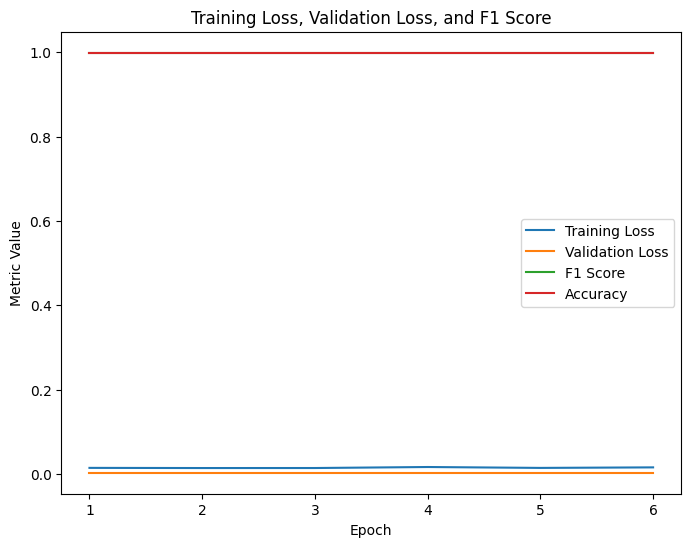

Epoch                 Training Loss         Validation Loss        F1 Score            Accuracy              Precision
--------------------  --------------------  ---------------------  ------------------  ------------------  -----------
1                     0.014720239329981628  0.0032380613600991527  0.9987616099071207  0.9987616099071207     0.998762
2                     0.014342368018126106  0.003238097336818983   0.9987616099071207  0.9987616099071207     0.998762
3                     0.014388396916094262  0.0032380265956637212  0.9987616099071207  0.9987616099071207     0.998762
4                     0.016767374300433412  0.0032380652889361667  0.9987616099071207  0.9987616099071207     0.998762
5                     0.014652283260859057  0.003238031399362599   0.9987616099071207  0.9987616099071207     0.998762
6                     0.01591455161799939   0.0032380601615021997  0.9987616099071207  0.9987616099071207     0.998762
Total Training Time                             

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.012001623856851421
Validation loss: 0.013428832642657113
F1 Score (weighted): 0.9981424148606811


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.013305548729161697
Validation loss: 0.013428940327559199
F1 Score (weighted): 0.9981424148606811
10.86% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.015400272020416546
Validation loss: 0.013428836039709874
F1 Score (weighted): 0.9981424148606811
15.74% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.012973504002194105
Validation loss: 0.013428835877756782
F1 Score (weighted): 0.9981424148606811
15.76% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 31.114033512274425 minutes
Final Accuracy: 0.9981424148606811
Final Precision: 0.9981424148606811


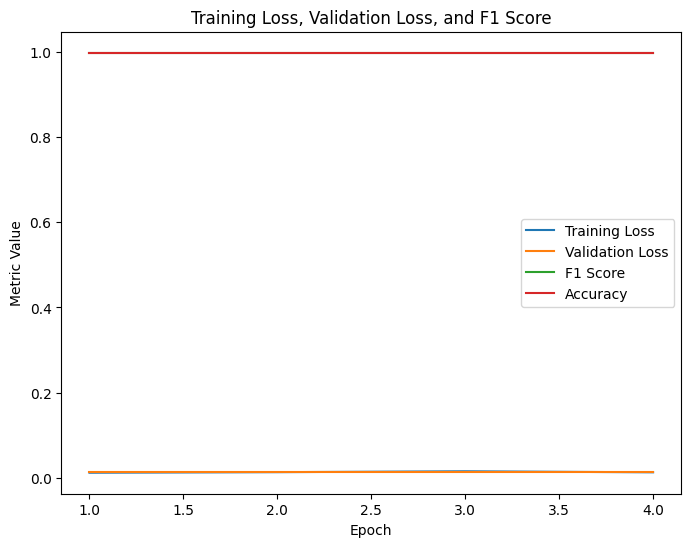

Epoch                 Training Loss         Validation Loss       F1 Score            Accuracy              Precision
--------------------  --------------------  --------------------  ------------------  ------------------  -----------
1                     0.012001623856851421  0.013428832642657113  0.9981424148606811  0.9981424148606811     0.998142
2                     0.013305548729161697  0.013428940327559199  0.9981424148606811  0.9981424148606811     0.998142
3                     0.015400272020416546  0.013428836039709874  0.9981424148606811  0.9981424148606811     0.998142
4                     0.012973504002194105  0.013428835877756782  0.9981424148606811  0.9981424148606811     0.998142
Total Training Time                                                                                       1866.84
Final Precision                                                                                              0.998142
Total Time (minutes)                                        

In [21]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Convert the multilabel indicator target to numpy array
targets = dataset_train.tensors[1].numpy()

# Initialize lists to store the evaluation metrics for each fold
training_loss_lists = []
validation_loss_lists = []
accuracy_lists = []
precision_lists = []
f1_score_lists = []

# Perform multilabel k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(targets)):
    print(f"\nFold {fold+1}")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    # Create data loaders for training and validation
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler)
    dataloader_vals = DataLoader(dataset_train, batch_size=batch_size, sampler=val_sampler)

    # Initialize metrics lists for this fold
    fold_training_loss_list = []
    fold_validation_loss_list = []
    fold_accuracy_list = []
    fold_precision_list = []
    fold_f1_score_list = []

    try:
        fold_training_loss_list, fold_validation_loss_list, fold_accuracy_list, fold_precision_list, fold_f1_score_list = \
        train_model(trainer, dataloader_train, dataloader_vals, epochs, patience)
    except Exception as e:
        print(f"Continue to the next fold {fold+1}: {str(e)}")
        continue

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.012324000463974185
Validation loss: 0.5557149947317874
F1 Score (weighted): 0.9193546568160291


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.012245110684588245
Validation loss: 0.5557148404927471
F1 Score (weighted): 0.9193546568160291
0.64% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.014351701455001207
Validation loss: 0.5557149256455736
F1 Score (weighted): 0.9193546568160291
17.2% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.013356834662214295
Validation loss: 0.555714973436652
F1 Score (weighted): 0.9193546568160291
6.93% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.012039267326397046
Validation loss: 0.5566982844025629
F1 Score (weighted): 0.9193546568160291
9.86% Training loss decreased compared to the previous epoch
0.18% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 38.88780568043391 minutes
Final Accuracy: 0.9184415584415584
Final Precision: 0.920373958526297


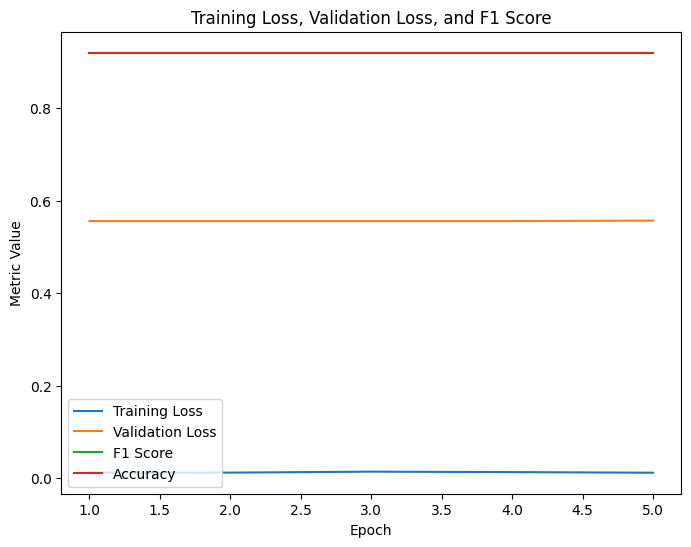

Epoch                 Training Loss         Validation Loss     F1 Score            Accuracy              Precision
--------------------  --------------------  ------------------  ------------------  ------------------  -----------
1                     0.012324000463974185  0.5557149947317874  0.9193546568160291  0.9184415584415584     0.920374
2                     0.012245110684588245  0.5557148404927471  0.9193546568160291  0.9193546568160291     0.919355
3                     0.014351701455001207  0.5557149256455736  0.9193546568160291  0.9193546568160291     0.919355
4                     0.013356834662214295  0.555714973436652   0.9193546568160291  0.9193546568160291     0.919355
5                     0.012039267326397046  0.5566982844025629  0.9193546568160291  0.9193546568160291     0.919355
Total Training Time                                                                                     2333.27
Final Precision                                                             

([0.012324000463974185,
  0.012245110684588245,
  0.014351701455001207,
  0.013356834662214295,
  0.012039267326397046],
 [0.5557149947317874,
  0.5557148404927471,
  0.5557149256455736,
  0.555714973436652,
  0.5566982844025629],
 [0.9184415584415584,
  0.9184415584415584,
  0.9184415584415584,
  0.9184415584415584,
  0.9184415584415584],
 [0.920373958526297,
  0.920373958526297,
  0.920373958526297,
  0.920373958526297,
  0.920373958526297],
 [0.9193546568160291,
  0.9193546568160291,
  0.9193546568160291,
  0.9193546568160291,
  0.9193546568160291])

In [22]:
train_model(trainer, dataloader_train, dataloader_val, epochs, patience)